<a href="https://colab.research.google.com/github/pmlab/pmlab-lite/blob/master/xes_certification/XES_Certification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **XES Certification**
---

In [1]:
!pip3 install pmlab_lite==0.4.5

     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for ciso8601: filename=ciso8601-2.1.3-cp37-cp37m-linux_x86_64.whl size=29073 sha256=649658d68bf8ca56b00763284659abe5a084dafebb790504ccc385ba2283dfe7
  Stored in directory: /root/.cache/pip/wheels/eb/32/e4/13bdaf7e245f82667b21e0cfb03d21224691a47fa9f9bc80a6
Successfully built ciso8601


In [1]:
from pmlab_lite.helper.io import xes
from pprint import pprint 
import graphviz as gr
from graphviz import Digraph

In [2]:
case_ids_ = {"bpic17": "Application_419883832",
             "b1": "48",
             "b2": "825",
             "c1": "64",
             "c2": "303",
             "d1": "1013",
             "d2": "190",
             "x1": "858", 
             "x2": "287"}

## Verification Functions
---

In [57]:
import random

def verify_log(log):
  """Prints the number of traces, events, the classifiers and a random trace of a log."""

  print("The log contains", len(log.traces), "traces and", len(log.events), "events.")
  print("Classifiers contained:", log.classifiers)
  idx = random.randint(0, len(log.traces)-1)
  log.print_traces(idx,1)

def print_rand_trace(log, attributes=None):
  idx = random.randint(0, len(log.traces)-1)
  print("Concept name of the trace:", log.traces[idx]['concept:name'], "(the same as the TRACE_ID below)")
  log.print_traces(idx,1, attributes)

def print_specific_case(log, trace_id, attributes=None):

  for idx, trace in log.traces.items():
    if trace['concept:name'] == trace_id:
      print("Concept name of the trace:", log.traces[idx]['concept:name'], "(the same as the TRACE_ID below)")
      log.print_traces(idx,1, attributes)

def print_specific_case2(log, trace_id):
  index = None
  for idx, trace in log.traces.items():
    if trace['concept:name'] == trace_id:
      index = idx

  print('Concept name of the trace:', log.traces[index]['concept:name'])
  print('Events belonging to this trace:')
  for event in log.get_traces()[index]:
    pprint(event)
    print()

def print_reimport(log):
  print("Number of traces in the log:", len(log.traces))
  print("Number of events in the log:", len(log.events))
  print("Classifiers in the log:", log.classifiers)
  print()
  print("Exporting and reimporting the log...")

  export = xes.export_to_xes(log, "test.xes")
  reimport = xes.import_xes("/content/test.xes")

  print()
  print("Number of traces in the reimported log:", len(reimport.traces))
  print("Number of events in the reimported log:", len(reimport.events))
  print("Classifiers in the reimported log:", reimport.classifiers)

def verify_filter_by_classifier(log, equal_events, classifier) -> bool:
  for i in range(len(equal_events)):
    for j in range(i+1, len(equal_events)):
      if not log.equal_by_classifier(equal_events[i], equal_events[j], classifier):
        return False
  return True

def dfg(log, lifecycle_present=True):
  
  activity_count, connections = {}, {}

  for trace_num in log.traces:
    
    # the dfg nodes in the report are named by activity name and lifecycle
    if lifecycle_present:
      event_list = [event['concept:name'] + '+' + event['lifecycle:transition'] for event in log.traces[trace_num] ['events']]
    elif len(list(log.classifiers.values())) > 0:
      classis = list(log.classifiers.values())[0]
      event_list = [event[classis[0]] + '+' + event[classis[1]] for event in log.traces[trace_num] ['events']]
    else:
      event_list = [event['concept:name'] for event in log.traces[trace_num] ['events']]
    
    for i in range(len(event_list)-1):
      activity_count[event_list[i]] = activity_count.get(event_list[i], 0) + 1
      if i == len(event_list)-2:
        activity_count[event_list[i+1]] = activity_count.get(event_list[i+1], 0) + 1
      connections[(event_list[i],event_list[i+1])] = connections.get((event_list[i],event_list[i+1]), 0) + 1
    
  return activity_count, connections

def draw_dfg(log, filename, threshold, format='png', save=True, lifecycle_present=True):  
  colors = ['edf8e9', "darkslategray2", "darkslategray3", "darkslategray4"]

  activity_count, connections = dfg(log, lifecycle_present)

  dot = Digraph(name=filename, format=format)

  dot.attr(rankdir='LR', fontsize="10", nodesep="0.35", ranksep="0.25 equally")
  # draw nodes
  dot.attr('node', penwidth="1", fontsize="10",
  		 fontname="Helvetica", shape='box', style='filled', colorscheme='greens4')

  for activity, amount in activity_count.items():
    if amount > 1500:
      color = '4'
    elif amount > 1000:
      color = '3'
    elif amount > 500:
      color = '2'
    else:
      color = '1'

    dot.node(str(activity) + ' (' + str(amount) + ')', color=color)

  # draw edges
  for node in connections:
    if connections[node] > threshold:
  	  dot.edge(str(node[0]+ ' (' + str(activity_count[node[0]]) + ')'), str(node[1]+ ' (' + str(activity_count[node[1]]) + ')'),
             label=str(connections[node]))

  if save:
    dot.format = 'png'
    dot.render('./' + filename + '.gv', view=False)

  return dot

In [6]:
!wget -O import_logs.zip http://www.win.tue.nl/ieeetfpm/lib/exe/fetch.php?media=shared:downloads:xes_certification_import_logs.zip

--2021-03-08 18:55:55--  http://www.win.tue.nl/ieeetfpm/lib/exe/fetch.php?media=shared:downloads:xes_certification_import_logs.zip
Resolving www.win.tue.nl (www.win.tue.nl)... 131.155.11.13
Connecting to www.win.tue.nl (www.win.tue.nl)|131.155.11.13|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.win.tue.nl/ieeetfpm/lib/exe/fetch.php?media=shared:downloads:xes_certification_import_logs.zip [following]
--2021-03-08 18:55:55--  https://www.win.tue.nl/ieeetfpm/lib/exe/fetch.php?media=shared:downloads:xes_certification_import_logs.zip
Connecting to www.win.tue.nl (www.win.tue.nl)|131.155.11.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54685689 (52M) [application/zip]
Saving to: ‘import_logs.zip’

import_logs.zip     100%[===================>]  52.15M  11.4MB/s    in 8.5s    

2021-03-08 18:56:04 (6.15 MB/s) - ‘import_logs.zip’ saved [54685689/54685689]



In [7]:
!unzip import_logs.zip && mv "XES certification import logs" XES_certification_import_logs

Archive:  import_logs.zip
   creating: XES certification import logs/
   creating: XES certification import logs/Artificial/
  inflating: XES certification import logs/Artificial/FlagX1.xes  
  inflating: XES certification import logs/Artificial/FlagX2.xes  
  inflating: XES certification import logs/Artificial/LevelA1.xes  
  inflating: XES certification import logs/Artificial/LevelA2.xes  
  inflating: XES certification import logs/Artificial/LevelB1.xes  
  inflating: XES certification import logs/Artificial/LevelB2.xes  
  inflating: XES certification import logs/Artificial/LevelC1.xes  
  inflating: XES certification import logs/Artificial/LevelC2.xes  
  inflating: XES certification import logs/Artificial/LevelD1.xes  
  inflating: XES certification import logs/Artificial/LevelD2.xes  
   creating: XES certification import logs/Real-life/
  inflating: XES certification import logs/Real-life/BPIC12.xes  
  inflating: XES certification import logs/Real-life/BPIC13_closed_problems.x

## File Paths
---

### File Paths to the Real Life Logs

In [109]:
a = './XES_certification_import_logs/Real-life/BPIC12.xes'                    
b = './XES_certification_import_logs/Real-life/BPIC13_closed_problems.xes'    
c = './XES_certification_import_logs/Real-life/BPIC13_incidents.xes'      
d = './XES_certification_import_logs/Real-life/BPIC13_open_problems.xes'  
e = './XES_certification_import_logs/Real-life/BPIC15_1.xes'                       
f = './XES_certification_import_logs/Real-life/BPIC15_2.xes'                
g = './XES_certification_import_logs/Real-life/BPIC15_3.xes'                 
h = './XES_certification_import_logs/Real-life/BPIC15_4.xes'                 
i = './XES_certification_import_logs/Real-life/BPIC15_5.xes'                 
j = './XES_certification_import_logs/Real-life/BPIC17 - Offer log.xes'    
k = './XES_certification_import_logs/Real-life/BPIC17.xes'                     

### File Paths to the Artificial Logs


In [5]:
pa1 = './XES_certification_import_logs/Artificial/LevelA1.xes'
pa2 = './XES_certification_import_logs/Artificial/LevelA2.xes'
pb1 = './XES_certification_import_logs/Artificial/LevelB1.xes'
pb2 = './XES_certification_import_logs/Artificial/LevelB2.xes'
pc1 = './XES_certification_import_logs/Artificial/LevelC1.xes'
pc2 = './XES_certification_import_logs/Artificial/LevelC2.xes'
pd1 = './XES_certification_import_logs/Artificial/LevelD1.xes'
pd2 = './XES_certification_import_logs/Artificial/LevelD2.xes'
px1 = './XES_certification_import_logs/Artificial/FlagX1.xes'
px2 = './XES_certification_import_logs/Artificial/FlagX2.xes' 

# **1 Importing**
---
---

## 1.1 Importing the Real-life Logs
---

### BPIC12 Log

In [55]:
log1 = xes.import_xes(a)
verify_log(log1)

18900it [00:00, 188997.03it/s]

Processing log...


2716052it [00:09, 271680.84it/s]

The log contains 13087 traces and 262200 events.
Classifiers contained: {'Activity classifier': ['concept:name', 'lifecycle:transition']}
TRACE_ID: 196990 (trace number 7476 )
  concept:name               lifecycle:transition                time:timestamp 
> A_SUBMITTED                COMPLETE                            01/01/2012 18:44:17.191000
> A_PARTLYSUBMITTED          COMPLETE                            01/01/2012 18:44:17.384000
> A_DECLINED                 COMPLETE                            01/01/2012 18:44:58.566000



### BPIC13_closed_problems Log

In [110]:
log2 = xes.import_xes(b)
verify_log(log2)

15095it [00:00, 150921.00it/s]

Processing log...


176720it [00:01, 124916.65it/s]

The log contains 1487 traces and 6660 events.
Classifiers contained: {'Activity classifier': ['concept:name', 'lifecycle:transition'], 'Resource classifier': ['org:resource']}
TRACE_ID: 909 (trace number 909 )
  concept:name            lifecycle:transition                time:timestamp 
> Accepted                In Progress                         01/17/2012 17:59:52.000000
> Completed               Closed                              01/17/2012 18:00:41.000000



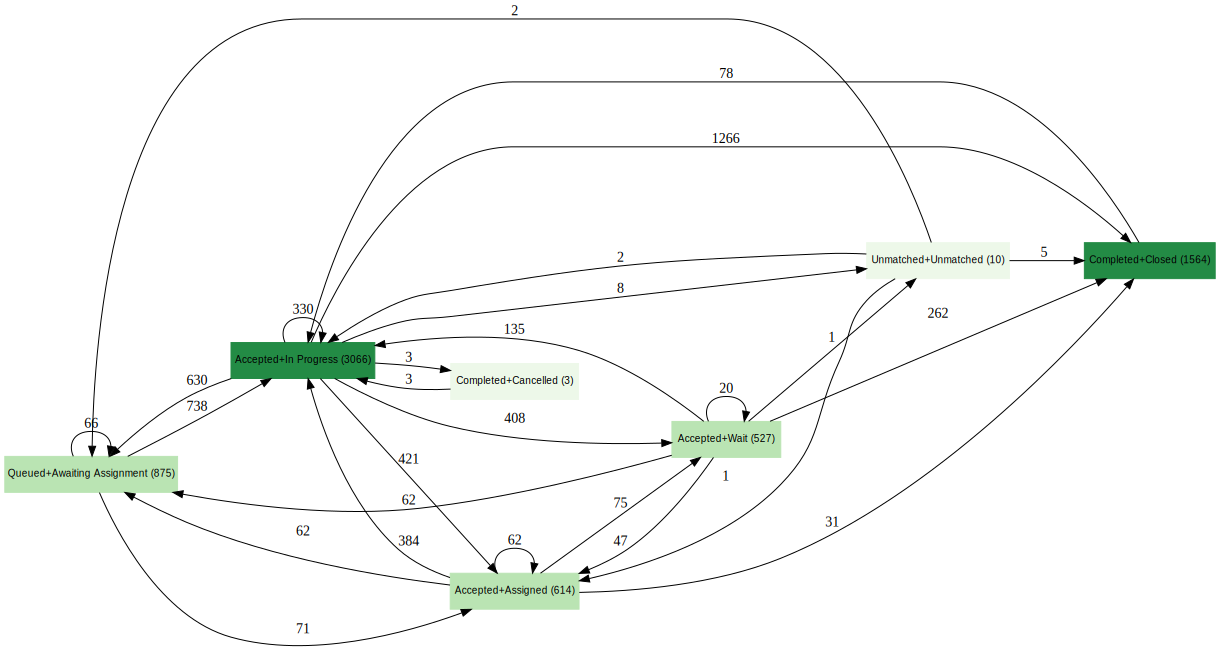

In [111]:
draw_dfg(log2, "log2", 0, save=False, lifecycle_present=True)

### BPIC13_incidents Log

In [ ]:
log3 = xes.import_xes(c)
verify_log(log3)

25854it [00:00, 258492.18it/s]

Processing log...


1634004it [00:05, 281513.26it/s]

The log contains 7554 traces and 65533 events.
Classifiers contained: {'Activity classifier': ['concept:name', 'lifecycle:transition'], 'Resource classifier': ['org:resource']}
TRACE_ID: 7522 (trace number 7522 )
  concept:name            lifecycle:transition                time:timestamp 
> Accepted                In Progress                         05/04/2012 22:00:25.000000
> Accepted                In Progress                         05/04/2012 22:01:20.000000
> Completed               In Call                             05/04/2012 22:02:17.000000



### BPIC13_open_problems Log

In [112]:
log4 = xes.import_xes(d)
verify_log(log4)

11858it [00:00, 118568.81it/s]

Processing log...


60864it [00:00, 125798.98it/s]

The log contains 819 traces and 2351 events.
Classifiers contained: {'Activity classifier': ['concept:name', 'lifecycle:transition'], 'Resource classifier': ['org:resource']}
TRACE_ID: 473 (trace number 473 )
  concept:name            lifecycle:transition                time:timestamp 
> Queued                  Awaiting Assignment                 05/04/2012 13:43:49.000000
> Accepted                In Progress                         05/04/2012 13:46:02.000000
> Queued                  Awaiting Assignment                 05/04/2012 13:54:17.000000
> Accepted                In Progress                         05/07/2012 11:47:48.000000
> Queued                  Awaiting Assignment                 05/07/2012 11:47:57.000000
> Accepted                In Progress                         05/07/2012 11:59:32.000000
> Queued                  Awaiting Assignment                 05/08/2012 14:06:45.000000
> Queued                  Awaiting Assignment                 05/16/2012 10:55:45.000000
>

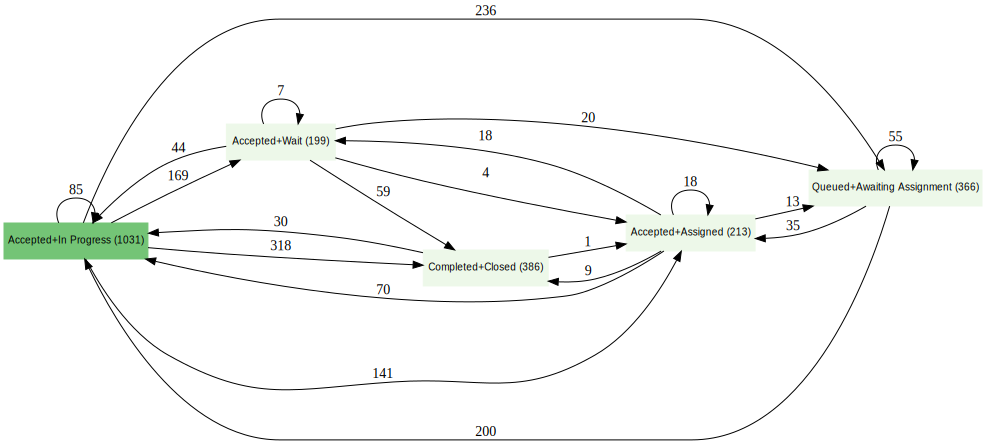

In [113]:
draw_dfg(log4, "log4", 0, save=False, lifecycle_present=True)

### BPIC15_1 Log

In [ ]:
log5 = xes.import_xes(e)
verify_log(log5)

25540it [00:00, 254418.19it/s]

Processing log...


1302812it [00:04, 294778.74it/s]

The log contains 1199 traces and 52217 events.
Classifiers contained: {'Activity classifier': ['concept:name', 'lifecycle:transition'], 'Activity classifier activityNameNL': ['activityNameNL', 'lifecycle:transition'], 'Activity classifier activityNameEN': ['activityNameEN', 'lifecycle:transition'], 'Resource': ['org:resource']}
TRACE_ID: 782 (trace number 782 )
  concept:name            lifecycle:transition                time:timestamp 
> 01_HOOFD_010            complete                            05/31/2012 00:00:00.000000
> 01_HOOFD_011            complete                            06/07/2012 10:12:18.000000
> 01_HOOFD_015            complete                            06/07/2012 10:12:18.000000
> 01_HOOFD_020            complete                            06/07/2012 10:12:21.000000
> 01_HOOFD_810            complete                            12/20/2012 14:32:11.000000
> 05_EIND_010             complete                            04/09/2013 14:30:29.000000
> 05_EIND_020           

### BPIC15_2 Log

In [ ]:
log6 = xes.import_xes(f)
verify_log(log6)

24566it [00:00, 245552.51it/s]

Processing log...


1089156it [00:03, 299900.34it/s]

The log contains 832 traces and 44354 events.
Classifiers contained: {'Activity classifier': ['concept:name', 'lifecycle:transition'], 'Activity classifier activityNameNL': ['activityNameNL', 'lifecycle:transition'], 'Activity classifier activityNameEN': ['activityNameEN', 'lifecycle:transition'], 'Resource': ['org:resource']}
TRACE_ID: 186 (trace number 186 )
  concept:name            lifecycle:transition                time:timestamp 
> 01_HOOFD_010            complete                            03/21/2013 00:00:00.000000
> 01_HOOFD_011            complete                            03/21/2013 14:36:10.000000
> 01_HOOFD_020            complete                            03/21/2013 14:36:10.000000
> 01_HOOFD_015            complete                            03/21/2013 14:36:10.000000
> 03_GBH_005              complete                            03/21/2013 14:36:11.000000
> 05_EIND_010             complete                            03/21/2013 14:36:11.000000
> 16_LGSV_010            

### BPIC15_3 Log

In [ ]:
log7 = xes.import_xes(g)
verify_log(log7)

22619it [00:00, 226186.44it/s]

Processing log...


1483078it [00:05, 274399.57it/s]

The log contains 1409 traces and 59681 events.
Classifiers contained: {'Activity classifier': ['concept:name', 'lifecycle:transition'], 'Activity classifier activityNameNL': ['activityNameNL', 'lifecycle:transition'], 'Activity classifier activityNameEN': ['activityNameEN', 'lifecycle:transition'], 'Resource': ['org:resource']}
TRACE_ID: 1037 (trace number 1037 )
  concept:name            lifecycle:transition                time:timestamp 
> 01_HOOFD_010            complete                            10/18/2013 00:00:00.000000
> 01_HOOFD_011            complete                            10/23/2013 00:00:00.000000
> 01_HOOFD_020            complete                            10/23/2013 00:00:00.000000
> 03_GBH_005              complete                            10/23/2013 00:00:00.000000
> 01_HOOFD_030_1          complete                            10/23/2013 00:00:00.000000
> 01_HOOFD_015            complete                            10/23/2013 00:00:00.000000
> 01_HOOFD_030_2      

### BPIC15_4 Log

In [ ]:
log8 = xes.import_xes(h)
verify_log(log8)

24106it [00:00, 240774.35it/s]

Processing log...


1171112it [00:04, 282651.45it/s]

The log contains 1053 traces and 47293 events.
Classifiers contained: {'Activity classifier': ['concept:name', 'lifecycle:transition'], 'Activity classifier activityNameNL': ['activityNameNL', 'lifecycle:transition'], 'Activity classifier activityNameEN': ['activityNameEN', 'lifecycle:transition'], 'Resource': ['org:resource']}
TRACE_ID: 684 (trace number 684 )
  concept:name            lifecycle:transition                time:timestamp 
> 01_HOOFD_010            complete                            12/18/2012 00:00:00.000000
> 01_HOOFD_011            complete                            12/20/2012 08:54:27.000000
> 01_HOOFD_020            complete                            12/20/2012 08:54:28.000000
> 03_GBH_005              complete                            12/20/2012 08:54:28.000000
> 16_LGSV_010             complete                            12/20/2012 08:54:28.000000
> 02_DRZ_010              complete                            12/20/2012 08:54:28.000000
> 01_HOOFD_015          

### BPIC15_5 Log


In [ ]:
log9 = xes.import_xes(i)
verify_log(log9)

19251it [00:00, 192454.20it/s]

Processing log...


1458092it [00:05, 287559.25it/s]

The log contains 1156 traces and 59083 events.
Classifiers contained: {'Activity classifier': ['concept:name', 'lifecycle:transition'], 'Activity classifier activityNameNL': ['activityNameNL', 'lifecycle:transition'], 'Activity classifier activityNameEN': ['activityNameEN', 'lifecycle:transition'], 'Resource': ['org:resource']}
TRACE_ID: 326 (trace number 326 )
  concept:name            lifecycle:transition                time:timestamp 
> 01_HOOFD_010            complete                            12/13/2010 00:00:00.000000
> 01_HOOFD_030_2          complete                            12/14/2010 00:00:00.000000
> 01_HOOFD_015            complete                            12/14/2010 12:05:34.000000
> 01_HOOFD_020            complete                            12/14/2010 12:05:51.000000
> 01_HOOFD_030_1          complete                            12/14/2010 12:09:13.000000
> 01_HOOFD_065_2          complete                            01/28/2011 00:00:00.000000
> 01_HOOFD_100          

### BPIC17 - Offer log

In [115]:
log10 = xes.import_xes(j)
verify_log(log10)

11108it [00:00, 111068.45it/s]

Processing log...


4303894it [00:34, 123248.18it/s]


The log contains 42995 traces and 193849 events.
Classifiers contained: {'Event Name': ['concept:name'], 'MXML Legacy Classifier': ['concept:name', 'lifecycle:transition'], 'Resource': ['org:resource']}
TRACE_ID: 39533 (trace number 39533 )
  concept:name            lifecycle:transition                time:timestamp 
> O_Create Offer          complete                            12/01/2016 12:52:31.547000
> O_Created               complete                            12/01/2016 12:52:32.134000
> O_Sent (mail and online)complete                            12/01/2016 12:52:39.401000
> O_Returned              complete                            12/13/2016 09:57:55.114000
> O_Refused               complete                            12/14/2016 11:55:15.318000



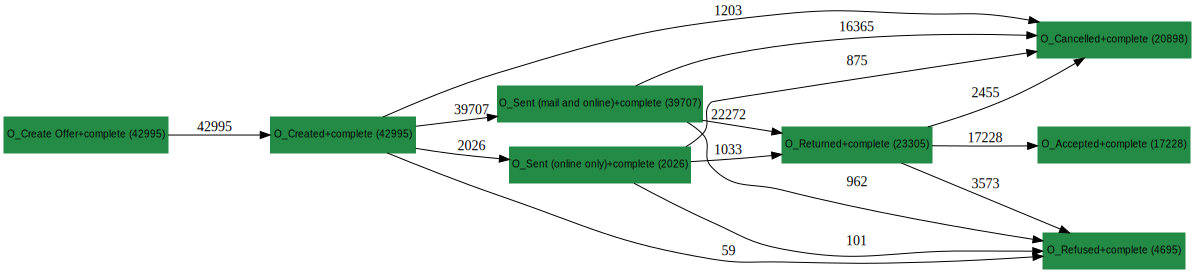

In [116]:
draw_dfg(log10, "log10", 0, save=False, lifecycle_present=True)

### BPIC17 Log

In [46]:
log11 = xes.import_xes(k)
verify_log(log11)

16673it [00:00, 166689.62it/s]

Processing log...


20586158it [01:10, 292374.01it/s]

The log contains 31509 traces and 1202267 events.
Classifiers contained: {'Event Name': ['concept:name'], 'MXML Legacy Classifier': ['concept:name', 'lifecycle:transition'], 'Resource': ['org:resource']}
TRACE_ID: Application_1953341305 (trace number 14708 )
  concept:name               lifecycle:transition                time:timestamp 
> A_Create Application       complete                            07/04/2016 18:21:37.236000
> A_Submitted                complete                            07/04/2016 18:21:37.293000
> W_Handle leads             schedule                            07/04/2016 18:21:37.711000
> W_Handle leads             withdraw                            07/04/2016 18:22:55.696000
> W_Complete application     schedule                            07/04/2016 18:22:55.712000
> A_Concept                  complete                            07/04/2016 18:22:55.719000
> W_Complete application     start                               07/04/2016 18:30:48.870000
> W_Complete app

In [ ]:
#print random trace
idx = random.randint(0, len(log11.traces)-1)

print('Concept name of the trace:', log11.traces[idx]['concept:name'])
print('Events belonging to this trace:')
for event in log11.get_traces()[idx]:
  pprint(event)
  print()

Concept name of the trace: Application_598655970
Events belonging to this trace:
{'Action': 'Created',
 'EventID': 'Application_598655970',
 'EventOrigin': 'Application',
 'concept:name': 'A_Create Application',
 'lifecycle:transition': 'complete',
 'org:resource': 'User_1',
 'time:timestamp': datetime.datetime(2016, 10, 18, 19, 14, 25, 126000, tzinfo=datetime.timezone.utc)}

{'Action': 'statechange',
 'EventID': 'ApplState_222919653',
 'EventOrigin': 'Application',
 'concept:name': 'A_Submitted',
 'lifecycle:transition': 'complete',
 'org:resource': 'User_1',
 'time:timestamp': datetime.datetime(2016, 10, 18, 19, 14, 25, 906000, tzinfo=datetime.timezone.utc)}

{'Action': 'Created',
 'EventID': 'Workitem_1524404378',
 'EventOrigin': 'Workflow',
 'concept:name': 'W_Handle leads',
 'lifecycle:transition': 'schedule',
 'org:resource': 'User_1',
 'time:timestamp': datetime.datetime(2016, 10, 18, 19, 14, 26, 49000, tzinfo=datetime.timezone.utc)}

{'Action': 'Deleted',
 'EventID': 'Workitem_

In [47]:
trace_id = case_ids_['bpic17']
print_specific_case2(log11, trace_id)

Concept name of the trace: Application_419883832
Events belonging to this trace:
{'Action': 'Created',
 'EventID': 'Application_419883832',
 'EventOrigin': 'Application',
 'concept:name': 'A_Create Application',
 'lifecycle:transition': 'complete',
 'org:resource': 'User_46',
 'time:timestamp': datetime.datetime(2016, 3, 30, 12, 15, 28, 708000, tzinfo=datetime.timezone.utc)}

{'Action': 'Created',
 'EventID': 'Workitem_1369577084',
 'EventOrigin': 'Workflow',
 'concept:name': 'W_Complete application',
 'lifecycle:transition': 'schedule',
 'org:resource': 'User_46',
 'time:timestamp': datetime.datetime(2016, 3, 30, 12, 15, 28, 718000, tzinfo=datetime.timezone.utc)}

{'Action': 'Obtained',
 'EventID': 'Workitem_936047951',
 'EventOrigin': 'Workflow',
 'concept:name': 'W_Complete application',
 'lifecycle:transition': 'start',
 'org:resource': 'User_46',
 'time:timestamp': datetime.datetime(2016, 3, 30, 12, 15, 28, 722000, tzinfo=datetime.timezone.utc)}

{'Action': 'statechange',
 'EventI

## 1.2 Importing and Verifying the Artifical Logs
---

### A1

In [41]:
a1 = xes.import_xes(pa1)

25555it [00:00, 131370.32it/s]

Processing log...


51850it [00:00, 136169.07it/s]


In [42]:
print("Traces:", len(a1.traces), "Events:", len(a1.events))

Traces: 1104 Events: 11855


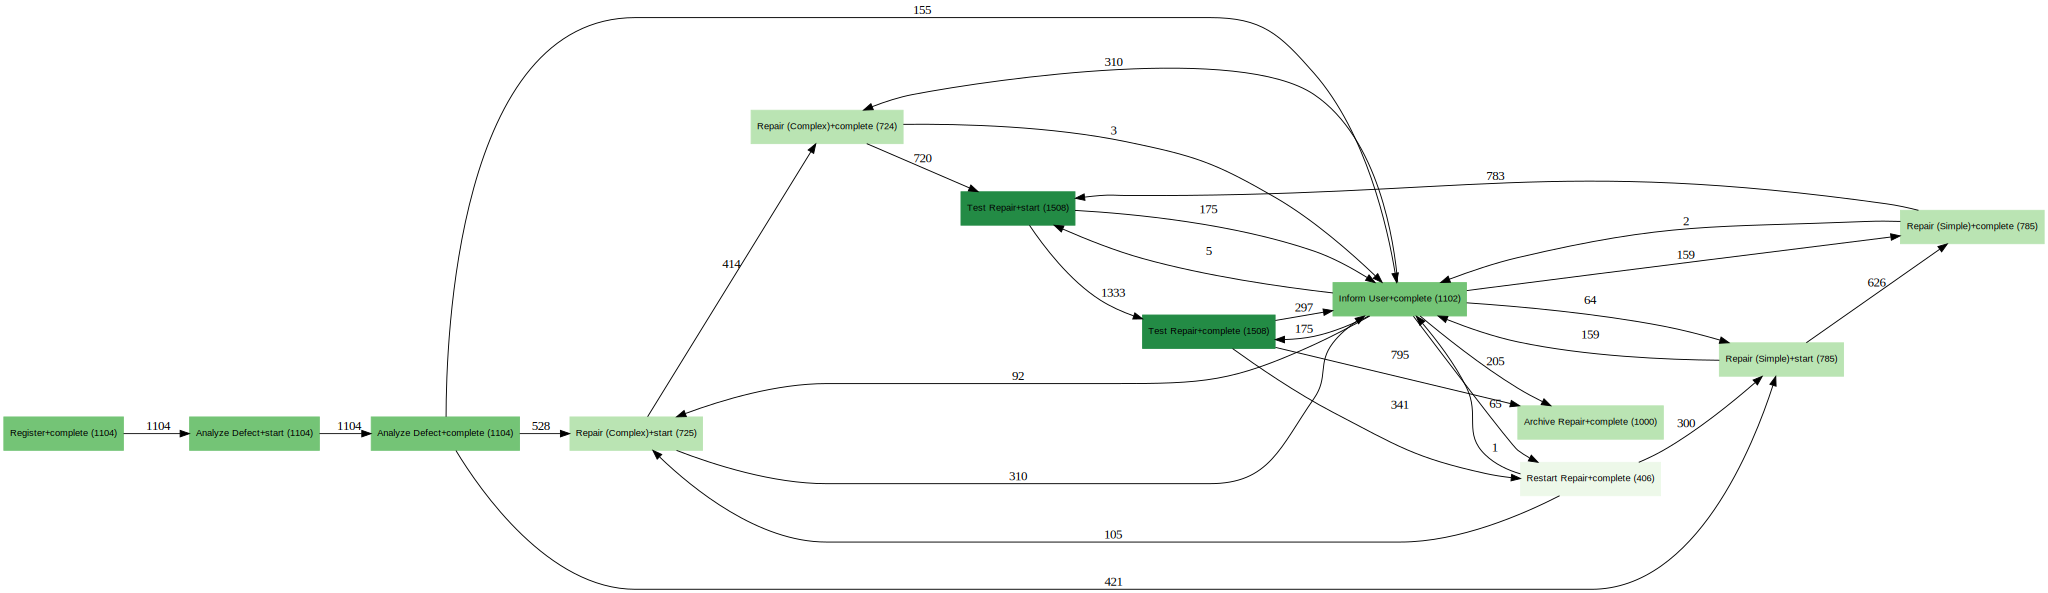

In [59]:
draw_dfg(a1, "a1", 0, save=False, lifecycle_present=False)

In [8]:
#print random event
idx = random.randint(0, len(a1.traces)-1)
pprint(a1.events[idx])                    # last idx 108, as seen in cell output

{'case:id': 100, 'concept:name': 'Test Repair+complete'}


In [ ]:
print_reimport(a1)

### A2

In [23]:
a2 = xes.import_xes(pa2)

10712it [00:00, 106758.92it/s]

Processing log...


75566it [00:00, 140309.11it/s]


In [ ]:
print("Traces:", len(a2.traces), "Events:", len(a2.events))

Traces: 1104 Events: 11855


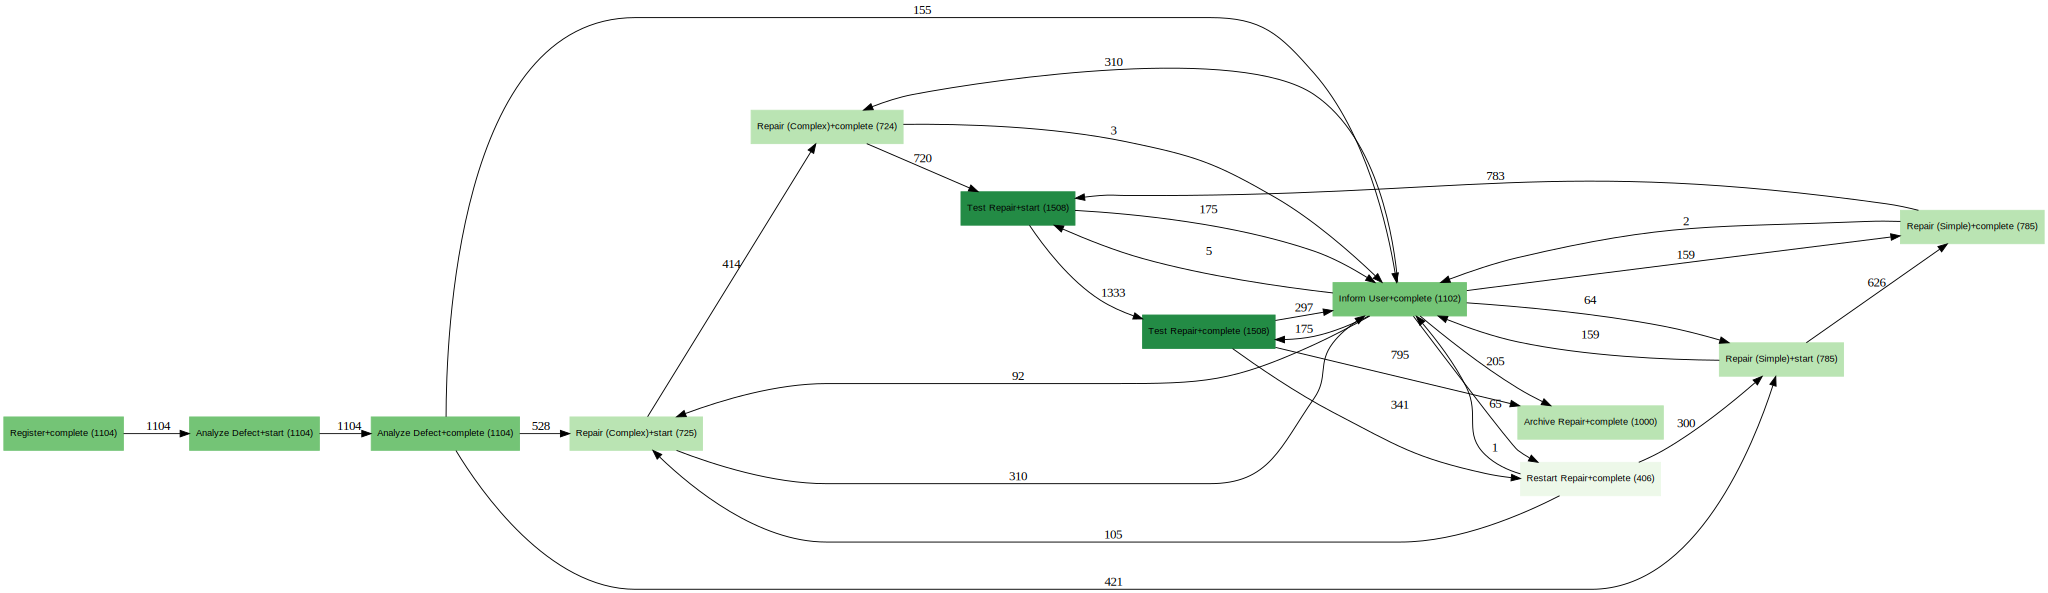

In [62]:
draw_dfg(a1, "a2", 0, save=False, lifecycle_present=False)

In [ ]:
#print random event
idx = random.randint(0, len(a2.traces)-1)
pprint(a2.events[idx])                    # last idx = 42, as seen in the cell output

{'case:id': 42,
 'concept:name': 'Inform User',
 'lifecycle:transition': 'complete'}


In [ ]:
a2.classifiers

{'(Name AND Transition)': ['concept:name', 'lifecycle:transition']}

In [ ]:
#build the set of event that is equal to the first event by our classifier
first_classifier = list(a2.classifiers.keys())[0]
equal_events = a2.filter_by_classifier(a2.events[0], first_classifier)
verify_filter_by_classifier(a2, equal_events, first_classifier)

True

### B1

In [63]:
b1 = xes.import_xes(pb1)

9314it [00:00, 92838.62it/s]

Processing log...


99278it [00:00, 127345.98it/s]


In [64]:
verify_log(b1)

The log contains 1104 traces and 11855 events.
Classifiers contained: {}
TRACE_ID: 814 (trace number 814 )
  concept:name            lifecycle:transition                time:timestamp 
> Register                complete                            02/07/1970 05:11:00.858000
> Analyze Defect          start                               02/07/1970 05:12:40.859000
> Analyze Defect          complete                            02/07/1970 05:21:44.210000
> Repair (Simple)         start                               02/07/1970 05:26:28.955000
> Repair (Simple)         complete                            02/07/1970 05:36:21.305000
> Test Repair             start                               02/07/1970 05:40:00.536000
> Test Repair             complete                            02/07/1970 05:53:04.187000
> Restart Repair          complete                            02/07/1970 06:03:02.591000
> Repair (Simple)         start                               02/07/1970 06:07:02.095000
> Repair (Simp

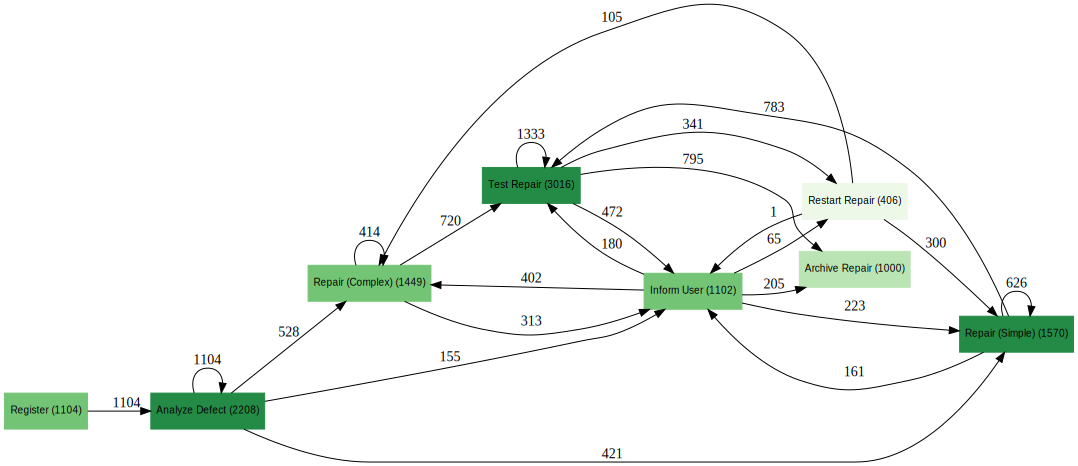

In [105]:
draw_dfg(b1, "b1", 0, save=False, lifecycle_present=False)

In [ ]:
print_rand_trace(b1)

Concept name of the trace: 48 (the same as the TRACE_ID below)
TRACE_ID: 48 (trace number 527 )
  concept:name               lifecycle:transition                time:timestamp 
> Register                   complete                            01/16/1970 15:13:21.730000
> Analyze Defect             start                               01/16/1970 15:16:20.158000
> Analyze Defect             complete                            01/16/1970 15:28:51.184000
> Repair (Simple)            start                               01/16/1970 15:59:56.116000
> Repair (Simple)            complete                            01/16/1970 16:09:42.081000
> Test Repair                start                               01/16/1970 16:12:59.906000
> Inform User                complete                            01/16/1970 16:20:27.840000
> Test Repair                complete                            01/16/1970 16:27:08.720000
> Restart Repair             complete                            01/16/1970 16:37:56.74

In [23]:
trace_id = case_ids_["b1"]
print_specific_case(b1, trace_id) 

Concept name of the trace: 48 (the same as the TRACE_ID below)
TRACE_ID: 48 (trace number 527 )
  concept:name               lifecycle:transition                time:timestamp 
> Register                   complete                            01/16/1970 15:13:21.730000
> Analyze Defect             start                               01/16/1970 15:16:20.158000
> Analyze Defect             complete                            01/16/1970 15:28:51.184000
> Repair (Simple)            start                               01/16/1970 15:59:56.116000
> Repair (Simple)            complete                            01/16/1970 16:09:42.081000
> Test Repair                start                               01/16/1970 16:12:59.906000
> Inform User                complete                            01/16/1970 16:20:27.840000
> Test Repair                complete                            01/16/1970 16:27:08.720000
> Restart Repair             complete                            01/16/1970 16:37:56.74

### B2

In [66]:
b2 = xes.import_xes(pb2)

9423it [00:00, 94220.43it/s]

Processing log...


99280it [00:00, 137616.01it/s]


In [67]:
verify_log(b2)

The log contains 1104 traces and 11855 events.
Classifiers contained: {'(Name AND Transition)': ['concept:name', 'lifecycle:transition']}
TRACE_ID: 685 (trace number 685 )
  concept:name            lifecycle:transition                time:timestamp 
> Register                complete                            01/29/1970 07:55:07.499000
> Analyze Defect          start                               01/29/1970 07:58:08.113000
> Analyze Defect          complete                            01/29/1970 08:09:15.296000
> Repair (Simple)         start                               01/29/1970 08:25:54.418000
> Repair (Simple)         complete                            01/29/1970 08:36:09.862000
> Test Repair             start                               01/29/1970 08:40:34.629000
> Inform User             complete                            01/29/1970 08:47:05.403000
> Test Repair             complete                            01/29/1970 08:53:00.038000
> Restart Repair          complete    

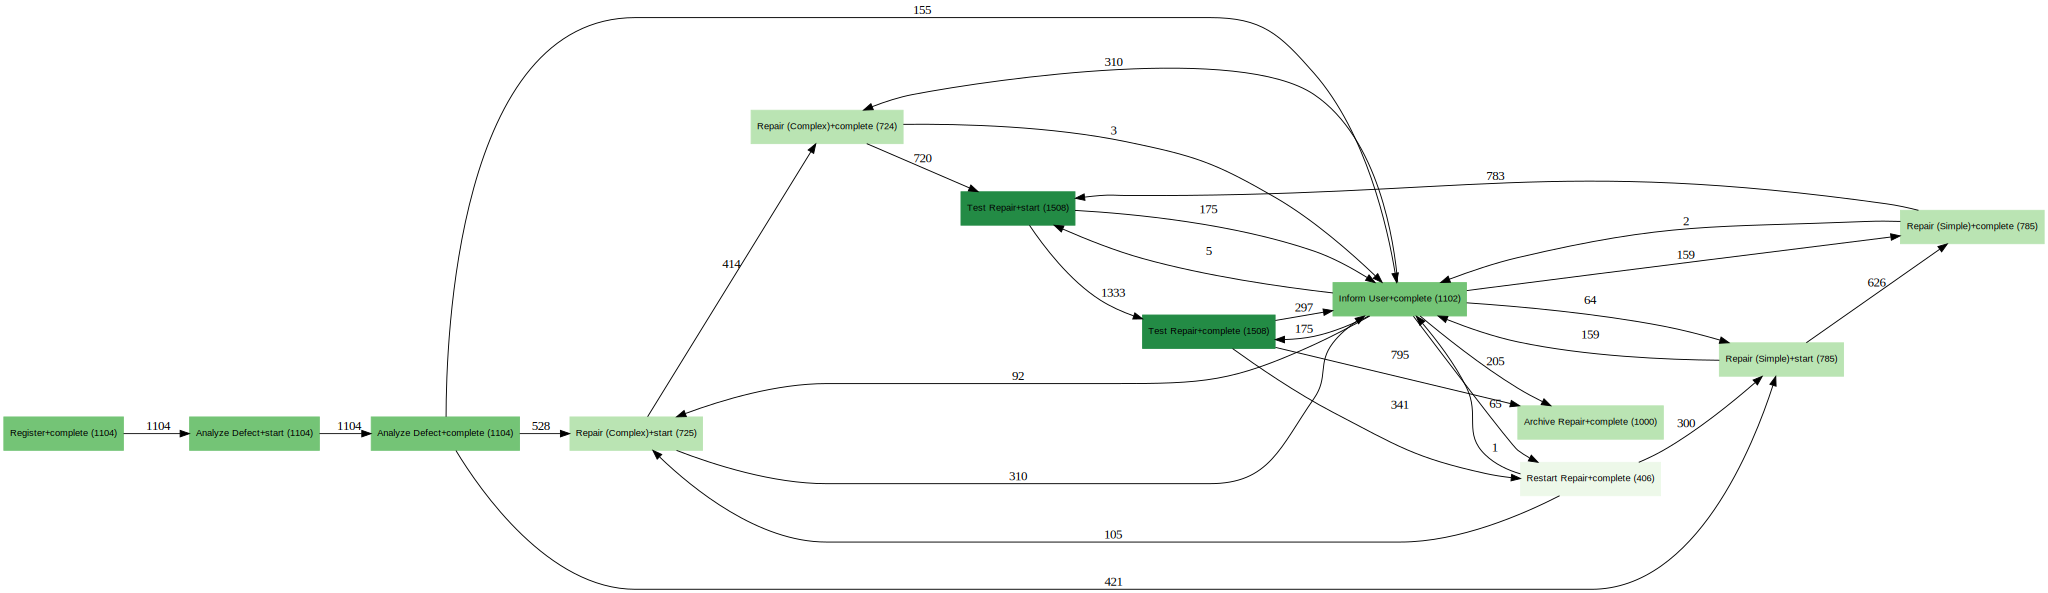

In [68]:
draw_dfg(b2, "b2", 0, save=False, lifecycle_present=True)

In [ ]:
print_rand_trace(b2)

Concept name of the trace: 825 (the same as the TRACE_ID below)
TRACE_ID: 825 (trace number 911 )
  concept:name               lifecycle:transition                time:timestamp 
> Register                   complete                            02/08/1970 21:00:14.152000
> Analyze Defect             start                               02/08/1970 21:02:31.053000
> Analyze Defect             complete                            02/08/1970 21:13:51.115000
> Repair (Simple)            start                               02/08/1970 21:43:41.416000
> Repair (Simple)            complete                            02/08/1970 21:54:13.299000
> Test Repair                start                               02/08/1970 21:58:27.104000
> Test Repair                complete                            02/08/1970 22:09:12.265000
> Inform User                complete                            02/08/1970 22:18:01.828000
> Restart Repair             complete                            02/08/1970 22:22:50.

In [ ]:
b2.classifiers

{'(Name AND Transition)': ['concept:name', 'lifecycle:transition']}

In [ ]:
#build the set of event that is equal to the first event by our classifier
first_classifier = list(b2.classifiers.keys())[0]
equal_events = b2.filter_by_classifier(b2.events[0], first_classifier)
verify_filter_by_classifier(b2, equal_events, first_classifier)

True

In [25]:
trace_id = case_ids_["b2"]
print_specific_case(b2, trace_id) 

Concept name of the trace: 825 (the same as the TRACE_ID below)
TRACE_ID: 825 (trace number 911 )
  concept:name               lifecycle:transition                time:timestamp 
> Register                   complete                            02/08/1970 21:00:14.152000
> Analyze Defect             start                               02/08/1970 21:02:31.053000
> Analyze Defect             complete                            02/08/1970 21:13:51.115000
> Repair (Simple)            start                               02/08/1970 21:43:41.416000
> Repair (Simple)            complete                            02/08/1970 21:54:13.299000
> Test Repair                start                               02/08/1970 21:58:27.104000
> Test Repair                complete                            02/08/1970 22:09:12.265000
> Inform User                complete                            02/08/1970 22:18:01.828000
> Restart Repair             complete                            02/08/1970 22:22:50.

### C1

In [69]:
c1 = xes.import_xes(pc1)

9685it [00:00, 96837.16it/s]

Processing log...


75564it [00:00, 142070.30it/s]


In [70]:
print("Traces:", len(c1.traces), "Events:", len(c1.events))

Traces: 1104 Events: 11855


In [71]:
attributes = ['concept:name', 'org:resource']

print_rand_trace(c1, attributes)

Concept name of the trace: 988 (the same as the TRACE_ID below)
TRACE_ID: 1093 (trace number 1093 )
  concept:name            org:resource                        
> Register+complete       System                              
> Analyze Defect+start    Tester2                             
> Analyze Defect+complete Tester2                             
> Inform User+complete    System                              
> Repair (Simple)+start   SolverS2                            
> Repair (Simple)+completeSolverS2                            
> Test Repair+start       Tester5                             
> Test Repair+complete    Tester5                             
> Archive Repair+complete System                              



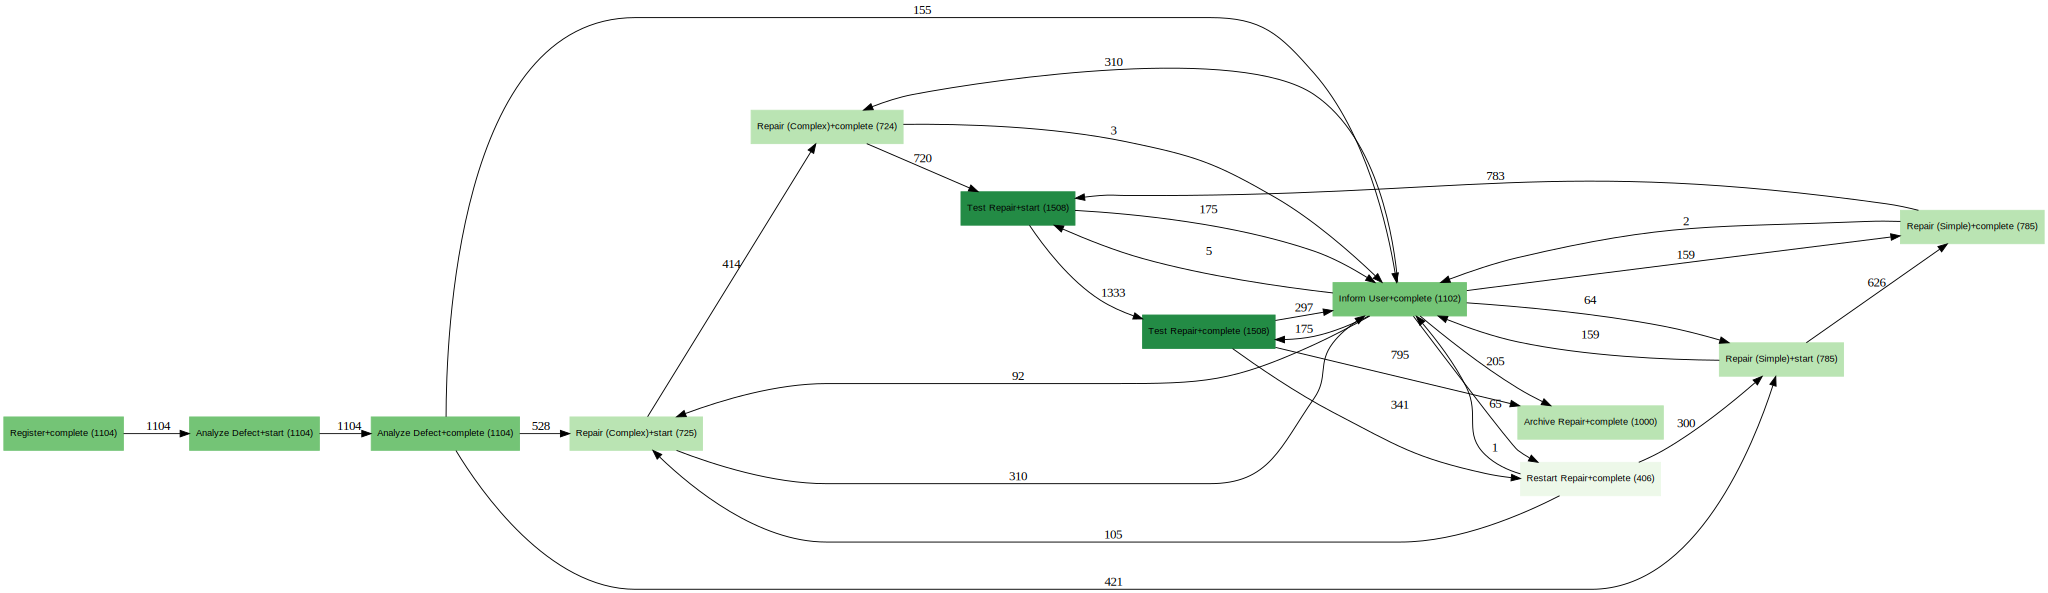

In [73]:
draw_dfg(c1, "c1", 0, save=False, lifecycle_present=False)

In [28]:
trace_id = case_ids_["c1"]
attributes = ['concept:name', 'org:resource']
print_specific_case(c1, trace_id, attributes) 

Concept name of the trace: 64 (the same as the TRACE_ID below)
TRACE_ID: 64 (trace number 705 )
  concept:name               org:resource                        
> Register+complete          System                              
> Analyze Defect+start       Tester5                             
> Analyze Defect+complete    Tester5                             
> Repair (Complex)+start     SolverC2                            
> Repair (Complex)+complete  SolverC2                            
> Test Repair+start          Tester1                             
> Test Repair+complete       Tester1                             
> Inform User+complete       System                              
> Archive Repair+complete    System                              



### C2

In [74]:
c2 = xes.import_xes(pc2)

5952it [00:00, 31413.38it/s]

Processing log...


99280it [00:00, 118826.81it/s]


In [75]:
print("Traces:", len(c2.traces), "Events:", len(c2.events))

Traces: 1104 Events: 11855


In [76]:
attributes = ['concept:name', 'lifecycle:transition', 'org:resource']

print_rand_trace(c2, attributes)

Concept name of the trace: 885 (the same as the TRACE_ID below)
TRACE_ID: 979 (trace number 979 )
  concept:name            lifecycle:transition                org:resource   
> Register                complete                            System         
> Analyze Defect          start                               Tester6        
> Analyze Defect          complete                            Tester6        
> Repair (Simple)         start                               SolverS3       
> Repair (Simple)         complete                            SolverS3       
> Test Repair             start                               Tester3        
> Inform User             complete                            System         
> Test Repair             complete                            Tester3        
> Archive Repair          complete                            System         



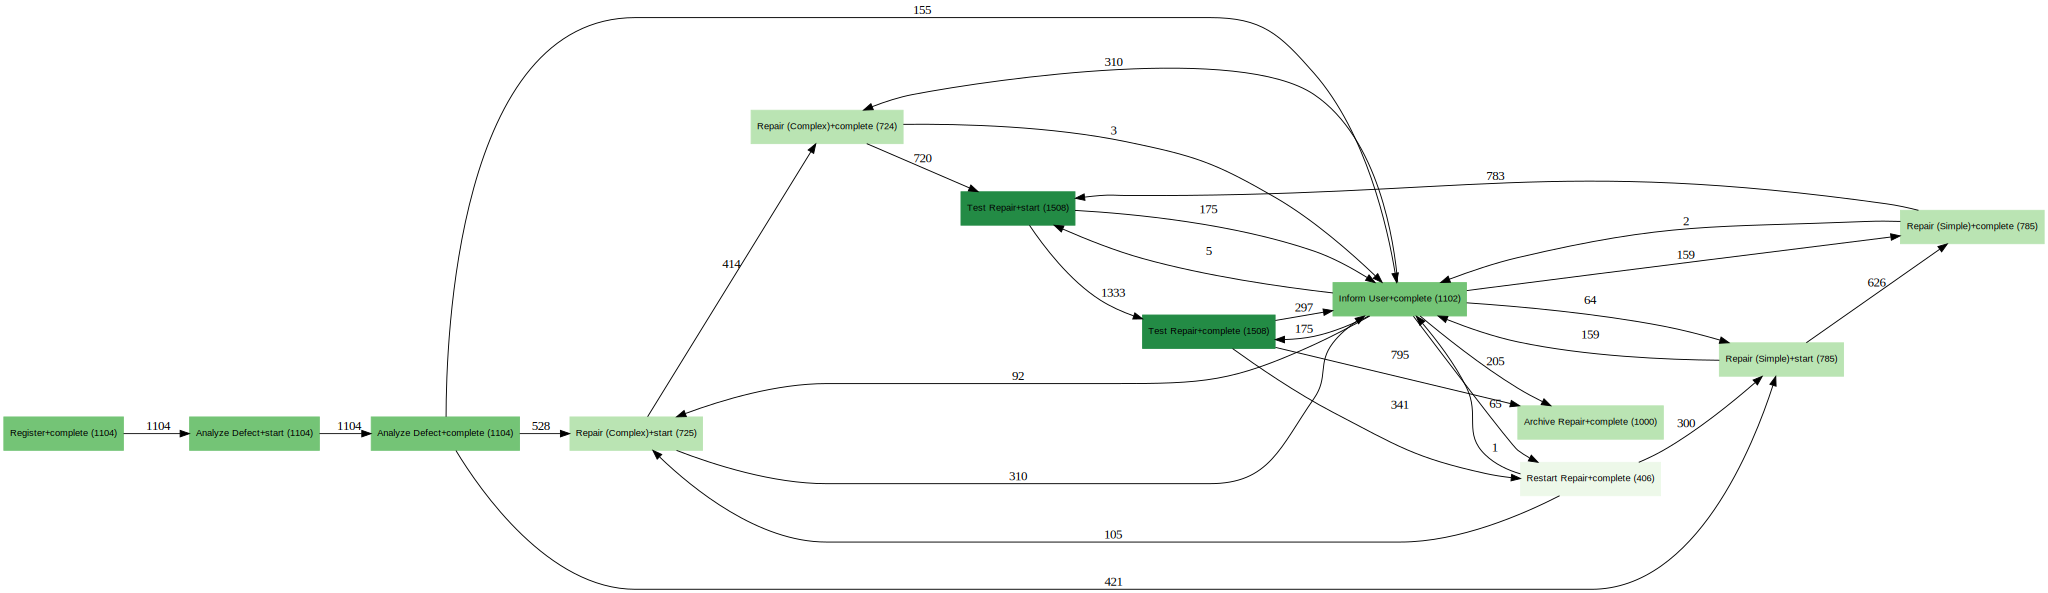

In [77]:
draw_dfg(c2, "c2", 0, save=False, lifecycle_present=True)

In [ ]:
c2.classifiers

{'(Name AND Transition)': ['concept:name', 'lifecycle:transition']}

In [ ]:
#build the set of event that is equal to the first event by our classifier
first_classifier = list(c2.classifiers.keys())[0]
equal_events = c2.filter_by_classifier(c2.events[0], first_classifier)
verify_filter_by_classifier(c2, equal_events, first_classifier)

True

In [30]:
trace_id = case_ids_["c2"]
attributes = ['concept:name', 'lifecycle:transition', 'org:resource']
print_specific_case(c2, trace_id, attributes) 

Concept name of the trace: 303 (the same as the TRACE_ID below)
TRACE_ID: 303 (trace number 332 )
  concept:name               lifecycle:transition                org:resource   
> Register                   complete                            System         
> Analyze Defect             start                               Tester6        
> Analyze Defect             complete                            Tester6        
> Repair (Complex)           start                               SolverC2       
> Repair (Complex)           complete                            SolverC2       
> Test Repair                start                               Tester3        
> Inform User                complete                            System         
> Test Repair                complete                            Tester3        
> Archive Repair             complete                            System         



### D1

In [91]:
d1 = xes.import_xes(pd1)

11582it [00:00, 115811.00it/s]

Processing log...


186902it [00:01, 124255.47it/s]


In [92]:
verify_log(d1)

The log contains 1104 traces and 11855 events.
Classifiers contained: {}
TRACE_ID: 965 (trace number 965 )
  concept:name            lifecycle:transition                time:timestamp 
> Register                complete                            02/05/1970 22:10:36.171000
> Analyze Defect          start                               02/05/1970 22:14:23.197000
> Analyze Defect          complete                            02/05/1970 22:24:14.961000
> Repair (Complex)        start                               02/05/1970 22:45:58.477000
> Inform User             complete                            02/05/1970 22:49:51.572000
> Repair (Complex)        complete                            02/05/1970 23:05:09.472000
> Test Repair             start                               02/05/1970 23:08:19.210000
> Test Repair             complete                            02/05/1970 23:20:10.821000
> Archive Repair          complete                            02/05/1970 23:32:31.227000



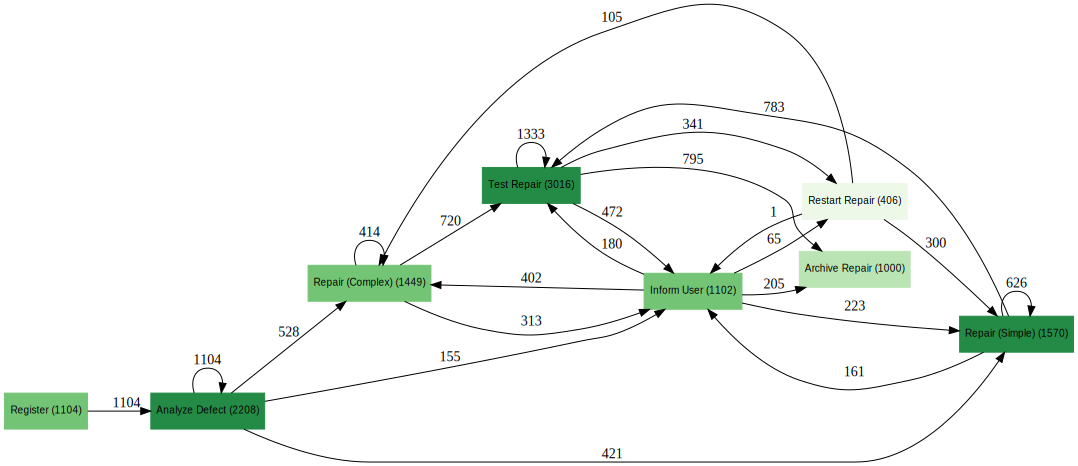

In [104]:
draw_dfg(d1, "d1", 0, save=False, lifecycle_present=False)

In [ ]:
#print random trace
idx = random.randint(0, len(d1.traces)-1)

print('Concept name of the trace:', d1.traces[idx]['concept:name'])
print('Events belonging to this trace:')
for event in d1.get_traces()[idx]:
  pprint(event)
  print()

Concept name of the trace: 1013
Events belonging to this trace:
{'concept:instance': 'instance 1',
 'concept:name': 'Register',
 'lifecycle:transition': 'complete',
 'org:group': 'Group -',
 'org:resource': 'System',
 'time:timestamp': datetime.datetime(1970, 1, 22, 9, 48, 43, 825000, tzinfo=datetime.timezone(datetime.timedelta(0, 3600)))}

{'concept:instance': 'instance 1',
 'concept:name': 'Analyze Defect',
 'lifecycle:transition': 'start',
 'org:group': 'Groups 2 and 4',
 'org:resource': 'Tester6',
 'org:role': 'Role 9',
 'time:timestamp': datetime.datetime(1970, 1, 22, 9, 51, 35, 829000, tzinfo=datetime.timezone(datetime.timedelta(0, 3600)))}

{'concept:instance': 'instance 1',
 'concept:name': 'Analyze Defect',
 'lifecycle:transition': 'complete',
 'org:group': 'Groups 2 and 4',
 'org:resource': 'Tester6',
 'org:role': 'Role 9',
 'time:timestamp': datetime.datetime(1970, 1, 22, 10, 1, 23, 520000, tzinfo=datetime.timezone(datetime.timedelta(0, 3600)))}

{'concept:instance': 'instan

In [39]:
trace_id = case_ids_['d1']
print_specific_case2(d1, trace_id)

Concept name of the trace: 1013
Events belonging to this trace:
{'concept:instance': 'instance 1',
 'concept:name': 'Register',
 'lifecycle:transition': 'complete',
 'org:group': 'Group -',
 'org:resource': 'System',
 'time:timestamp': datetime.datetime(1970, 1, 22, 9, 48, 43, 825000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600)))}

{'concept:instance': 'instance 1',
 'concept:name': 'Analyze Defect',
 'lifecycle:transition': 'start',
 'org:group': 'Groups 2 and 4',
 'org:resource': 'Tester6',
 'org:role': 'Role 9',
 'time:timestamp': datetime.datetime(1970, 1, 22, 9, 51, 35, 829000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600)))}

{'concept:instance': 'instance 1',
 'concept:name': 'Analyze Defect',
 'lifecycle:transition': 'complete',
 'org:group': 'Groups 2 and 4',
 'org:resource': 'Tester6',
 'org:role': 'Role 9',
 'time:timestamp': datetime.datetime(1970, 1, 22, 10, 1, 23, 520000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600)))}

{'concept:ins

### D2

In [81]:
d2 = xes.import_xes(pd2)

10954it [00:00, 109531.23it/s]

Processing log...


186904it [00:01, 126943.89it/s]


In [82]:
verify_log(d2)

The log contains 1104 traces and 11855 events.
Classifiers contained: {'(Name AND Transition)': ['concept:name', 'lifecycle:transition']}
TRACE_ID: 278 (trace number 278 )
  concept:name            lifecycle:transition                time:timestamp 
> Register                complete                            01/11/1970 22:55:56.264000
> Analyze Defect          start                               01/11/1970 22:58:25.831000
> Analyze Defect          complete                            01/11/1970 23:09:32.436000
> Repair (Simple)         start                               01/11/1970 23:20:02.838000
> Repair (Simple)         complete                            01/11/1970 23:25:55.397000
> Test Repair             start                               01/11/1970 23:27:08.003000
> Test Repair             complete                            01/11/1970 23:37:47.538000
> Restart Repair          complete                            01/11/1970 23:48:39.505000
> Repair (Complex)        start       

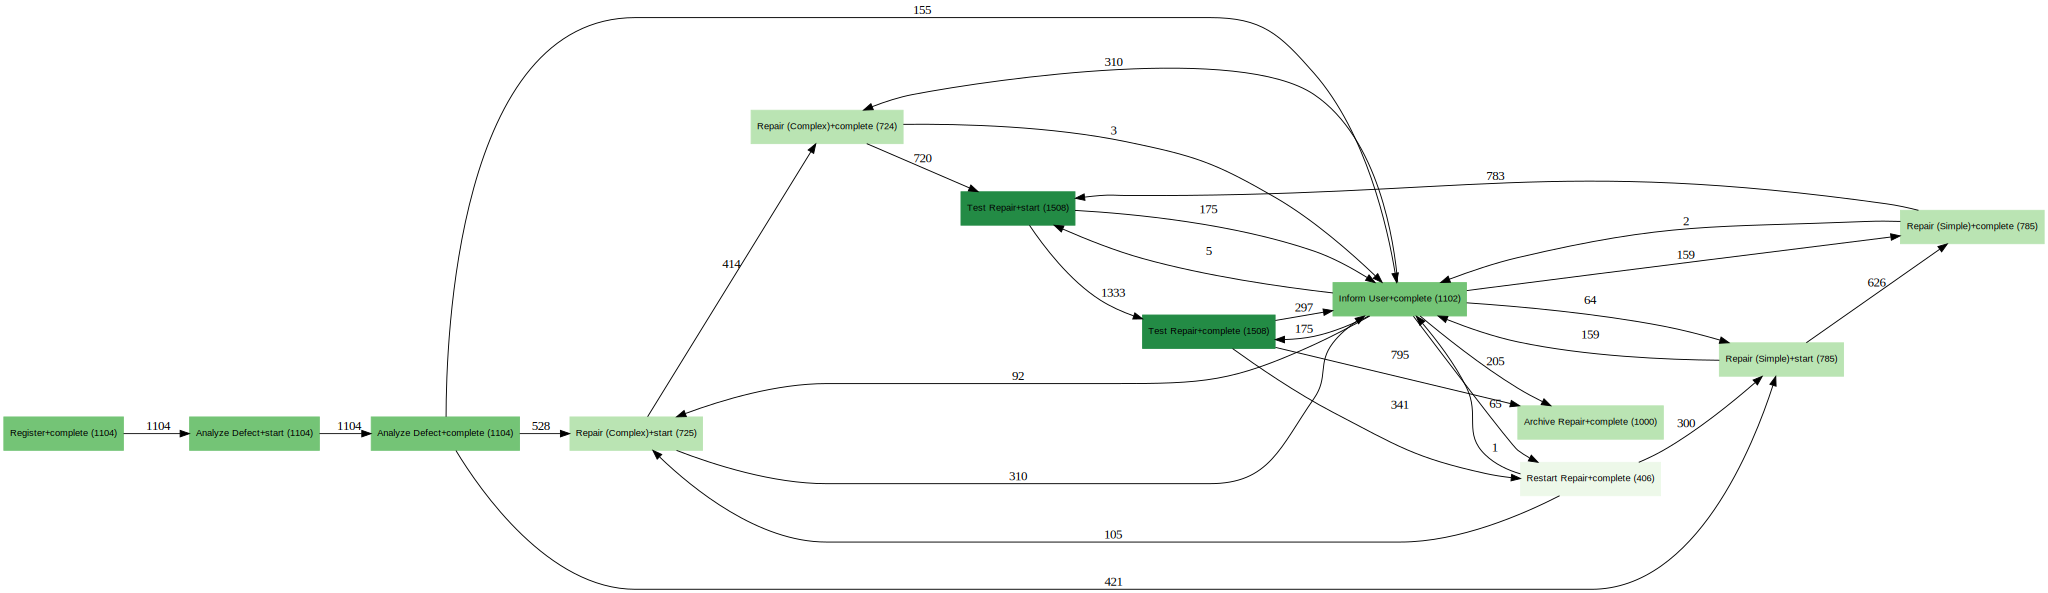

In [83]:
draw_dfg(d2, "d2", 0, save=False, lifecycle_present=True)

In [ ]:
#print random trace
idx = random.randint(0, len(d2.traces)-1)

print('Concept name of the trace:', d2.traces[idx]['concept:name'])
print('Events belonging to this trace:')
for event in d2.get_traces()[idx]:
  pprint(event)
  print()

Concept name of the trace: 190
Events belonging to this trace:
{'concept:instance': 'instance 1',
 'concept:name': 'Register',
 'lifecycle:transition': 'complete',
 'org:group': 'Group -',
 'org:resource': 'System',
 'time:timestamp': datetime.datetime(1970, 1, 8, 6, 39, 51, 325000, tzinfo=datetime.timezone(datetime.timedelta(0, 3600)))}

{'concept:instance': 'instance 1',
 'concept:name': 'Analyze Defect',
 'lifecycle:transition': 'start',
 'org:group': 'Groups 2 and 4',
 'org:resource': 'Tester3',
 'org:role': 'Role 9',
 'time:timestamp': datetime.datetime(1970, 1, 8, 6, 42, 18, 603000, tzinfo=datetime.timezone(datetime.timedelta(0, 3600)))}

{'concept:instance': 'instance 1',
 'concept:name': 'Analyze Defect',
 'lifecycle:transition': 'complete',
 'org:group': 'Groups 2 and 4',
 'org:resource': 'Tester3',
 'org:role': 'Role 9',
 'time:timestamp': datetime.datetime(1970, 1, 8, 6, 51, 11, 283000, tzinfo=datetime.timezone(datetime.timedelta(0, 3600)))}

{'concept:instance': 'instance 1

In [ ]:
d2.classifiers

{'(Name AND Transition)': ['concept:name', 'lifecycle:transition']}

In [ ]:
#build the set of event that is equal to the first event by our classifier
first_classifier = list(d2.classifiers.keys())[0]
equal_events = d2.filter_by_classifier(d2.events[0], first_classifier)
verify_filter_by_classifier(d2, equal_events, first_classifier)

True

In [41]:
trace_id = case_ids_['d2']
print_specific_case2(d2, trace_id)

Concept name of the trace: 190
Events belonging to this trace:
{'concept:instance': 'instance 1',
 'concept:name': 'Register',
 'lifecycle:transition': 'complete',
 'org:group': 'Group -',
 'org:resource': 'System',
 'time:timestamp': datetime.datetime(1970, 1, 8, 6, 39, 51, 325000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600)))}

{'concept:instance': 'instance 1',
 'concept:name': 'Analyze Defect',
 'lifecycle:transition': 'start',
 'org:group': 'Groups 2 and 4',
 'org:resource': 'Tester3',
 'org:role': 'Role 9',
 'time:timestamp': datetime.datetime(1970, 1, 8, 6, 42, 18, 603000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600)))}

{'concept:instance': 'instance 1',
 'concept:name': 'Analyze Defect',
 'lifecycle:transition': 'complete',
 'org:group': 'Groups 2 and 4',
 'org:resource': 'Tester3',
 'org:role': 'Role 9',
 'time:timestamp': datetime.datetime(1970, 1, 8, 6, 51, 11, 283000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600)))}

{'concept:instanc

### X1

In [84]:
x1 = xes.import_xes(px1)

10627it [00:00, 106260.73it/s]

Processing log...


220036it [00:01, 129465.08it/s]


In [85]:
#print random event
idx = random.randint(0, len(x1.traces)-1)
pprint(x1.events[idx])

{'ITEMS:41, #1, o.1.1': 'Roles 1, 2, and 3',
 'Key 1': 'Repair (Simple)',
 'Key 2': 'instance 2',
 'Key 3': 'SolverS2',
 'Key 4': datetime.datetime(1970, 1, 1, 13, 44, 2, 661000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 'Key 6': 'complete',
 'case:id': 2,
 '{0,1,2} 2Sa!! +1 &lt;x&gt;': 'Groups 1, 3, and 5'}


In [ ]:
#@title Default title text
#print random trace
idx = random.randint(0, len(x1.traces)-1)

print('Concept name of the trace:', x1.traces[idx]['concept:name'])
print('Events belonging to this trace:')
for event in x1.get_traces()[idx]:
  pprint(event)
  print()

Concept name of the trace: 858
Events belonging to this trace:
{'Key 1': 'Register',
 'Key 2': 'instance 1',
 'Key 3': 'System',
 'Key 4': datetime.datetime(1970, 2, 24, 0, 40, 23, 584000, tzinfo=datetime.timezone(datetime.timedelta(0, 3600))),
 'Key 6': 'complete',
 'numberRepairs': 1,
 '{0,1,2} 2Sa!! +1 &lt;x&gt;': 'Group -'}

{'ITEMS:41, #1, o.1.1': 'Role 9',
 'Key 1': 'Analyze Defect',
 'Key 2': 'instance 1',
 'Key 3': 'Tester2',
 'Key 4': datetime.datetime(1970, 2, 24, 0, 45, 58, 751000, tzinfo=datetime.timezone(datetime.timedelta(0, 3600))),
 'Key 6': 'start',
 'numberRepairs': 2,
 '{0,1,2} 2Sa!! +1 &lt;x&gt;': 'Groups 2 and 4'}

{'ITEMS:41, #1, o.1.1': 'Role 9',
 'Key 1': 'Analyze Defect',
 'Key 2': 'instance 1',
 'Key 3': 'Tester2',
 'Key 4': datetime.datetime(1970, 2, 24, 0, 58, 37, 791000, tzinfo=datetime.timezone(datetime.timedelta(0, 3600))),
 'Key 6': 'complete',
 'defectType': 10,
 'numberRepairs': 3,
 'phoneType': 'T2',
 '{0,1,2} 2Sa!! +1 &lt;x&gt;': 'Groups 2 and 4'}

{

In [43]:
trace_id = case_ids_['x1']
print_specific_case2(x1, trace_id)

Concept name of the trace: 858
Events belonging to this trace:
{'Key 1': 'Register',
 'Key 2': 'instance 1',
 'Key 3': 'System',
 'Key 4': datetime.datetime(1970, 2, 24, 0, 40, 23, 584000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 'Key 6': 'complete',
 'numberRepairs': 1,
 '{0,1,2} 2Sa!! +1 &lt;x&gt;': 'Group -'}

{'ITEMS:41, #1, o.1.1': 'Role 9',
 'Key 1': 'Analyze Defect',
 'Key 2': 'instance 1',
 'Key 3': 'Tester2',
 'Key 4': datetime.datetime(1970, 2, 24, 0, 45, 58, 751000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 'Key 6': 'start',
 'numberRepairs': 2,
 '{0,1,2} 2Sa!! +1 &lt;x&gt;': 'Groups 2 and 4'}

{'ITEMS:41, #1, o.1.1': 'Role 9',
 'Key 1': 'Analyze Defect',
 'Key 2': 'instance 1',
 'Key 3': 'Tester2',
 'Key 4': datetime.datetime(1970, 2, 24, 0, 58, 37, 791000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 'Key 6': 'complete',
 'defectType': 10,
 'numberRepairs': 3,
 'phoneType': 'T2',
 '{0,1,2} 2Sa!! +1 &lt;x&gt;': 'Grou

### X2

In [87]:
x2 = xes.import_xes(px2)

10400it [00:00, 103985.72it/s]

Processing log...


220038it [00:01, 137101.13it/s]


In [88]:
#print random event
idx = random.randint(0, len(x2.traces)-1)
pprint(x2.events[idx])

{'ITEMS:41, #1, o.1.1': 'Role 10',
 'Key 1': 'Repair (Complex)',
 'Key 2': 'instance 1',
 'Key 3': 'SolverC1',
 'Key 4': datetime.datetime(1970, 1, 25, 3, 15, 18, 728000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 'Key 6': 'start',
 'case:id': 56,
 '{0,1,2} 2Sa!! +1 &lt;x&gt;': 'Groups 1, 3, and 5'}


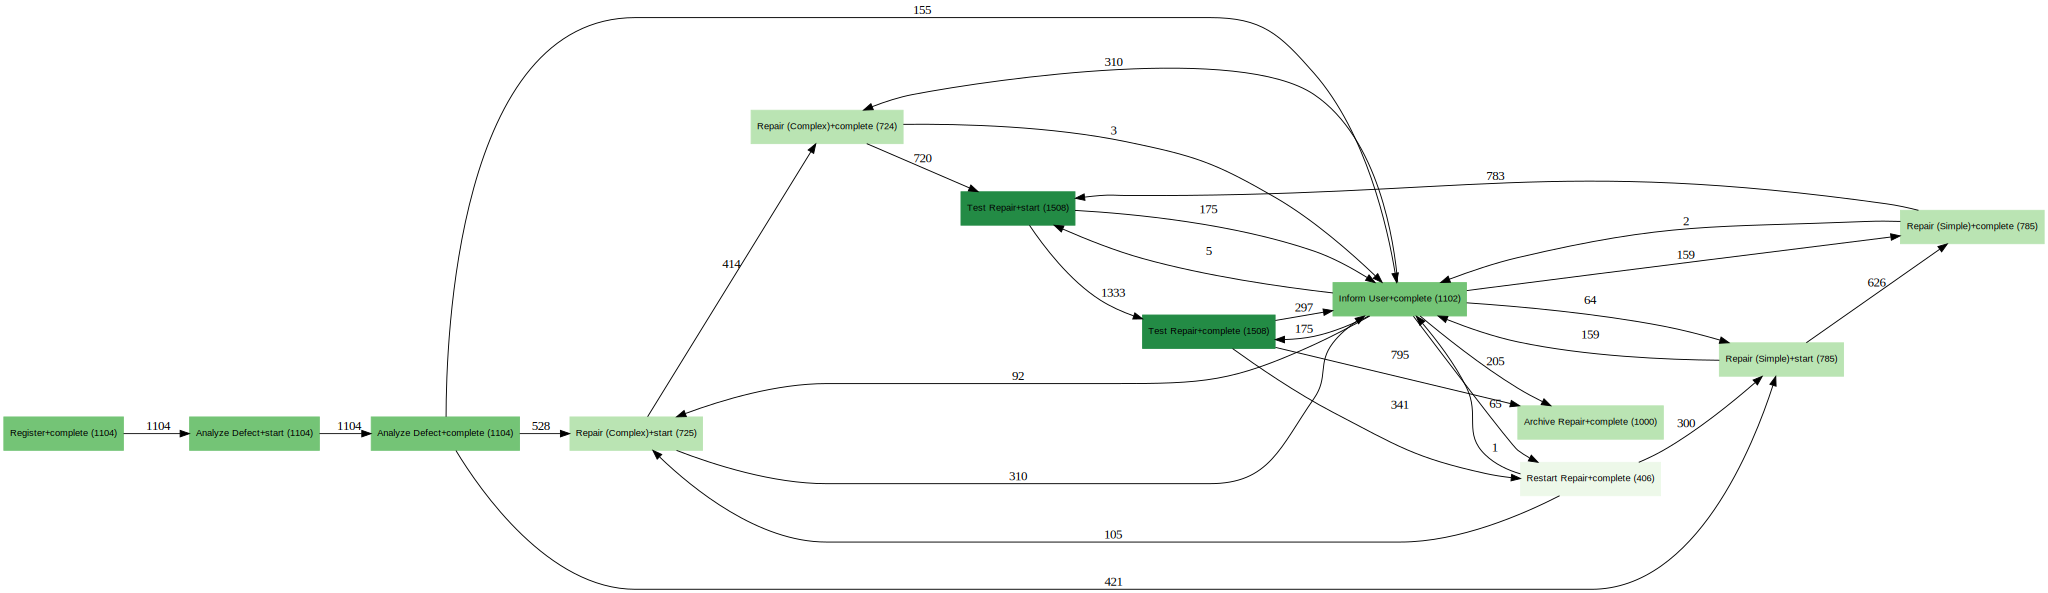

In [90]:
draw_dfg(x2, "x2", 0, save=False, lifecycle_present=False)

In [ ]:
#print random trace
idx = random.randint(0, len(x2.traces)-1)

print('Concept name of the trace:', x2.traces[idx]['concept:name'])
print('Events belonging to this trace:')
for event in x2.get_traces()[idx]:
  pprint(event)
  print()

Concept name of the trace: 287
Events belonging to this trace:
{'Key 1': 'Register',
 'Key 2': 'instance 1',
 'Key 3': 'System',
 'Key 4': datetime.datetime(1970, 1, 17, 15, 11, 25, 104000, tzinfo=datetime.timezone(datetime.timedelta(0, 3600))),
 'Key 6': 'complete',
 'numberRepairs': 1,
 '{0,1,2} 2Sa!! +1 &lt;x&gt;': 'Group -'}

{'ITEMS:41, #1, o.1.1': 'Role 9',
 'Key 1': 'Analyze Defect',
 'Key 2': 'instance 1',
 'Key 3': 'Tester2',
 'Key 4': datetime.datetime(1970, 1, 17, 15, 16, 46, 88000, tzinfo=datetime.timezone(datetime.timedelta(0, 3600))),
 'Key 6': 'start',
 'numberRepairs': 2,
 '{0,1,2} 2Sa!! +1 &lt;x&gt;': 'Groups 2 and 4'}

{'ITEMS:41, #1, o.1.1': 'Role 9',
 'Key 1': 'Analyze Defect',
 'Key 2': 'instance 1',
 'Key 3': 'Tester2',
 'Key 4': datetime.datetime(1970, 1, 17, 15, 27, 2, 510000, tzinfo=datetime.timezone(datetime.timedelta(0, 3600))),
 'Key 6': 'complete',
 'defectType': 6,
 'numberRepairs': 3,
 'phoneType': 'T3',
 '{0,1,2} 2Sa!! +1 &lt;x&gt;': 'Groups 2 and 4'}

{

In [ ]:
x2.classifiers

{'(Name AND Transition)': ['Key 1', 'Key 6']}

In [ ]:
#build the set of event that is equal to the first event by our classifier
first_classifier = list(x2.classifiers.keys())[0]
equal_events = x2.filter_by_classifier(x2.events[0], first_classifier)
verify_filter_by_classifier(x2, equal_events, first_classifier)

True

In [45]:
trace_id = case_ids_['x2']
print_specific_case2(x2, trace_id)

Concept name of the trace: 287
Events belonging to this trace:
{'Key 1': 'Register',
 'Key 2': 'instance 1',
 'Key 3': 'System',
 'Key 4': datetime.datetime(1970, 1, 17, 15, 11, 25, 104000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 'Key 6': 'complete',
 'numberRepairs': 1,
 '{0,1,2} 2Sa!! +1 &lt;x&gt;': 'Group -'}

{'ITEMS:41, #1, o.1.1': 'Role 9',
 'Key 1': 'Analyze Defect',
 'Key 2': 'instance 1',
 'Key 3': 'Tester2',
 'Key 4': datetime.datetime(1970, 1, 17, 15, 16, 46, 88000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 'Key 6': 'start',
 'numberRepairs': 2,
 '{0,1,2} 2Sa!! +1 &lt;x&gt;': 'Groups 2 and 4'}

{'ITEMS:41, #1, o.1.1': 'Role 9',
 'Key 1': 'Analyze Defect',
 'Key 2': 'instance 1',
 'Key 3': 'Tester2',
 'Key 4': datetime.datetime(1970, 1, 17, 15, 27, 2, 510000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 'Key 6': 'complete',
 'defectType': 6,
 'numberRepairs': 3,
 'phoneType': 'T3',
 '{0,1,2} 2Sa!! +1 &lt;x&gt;': 'Grou

# **2 Exporting**
---
---

In [57]:
# here the reimport can be done, inject a log variable name (corresponds to the first screenshot for each log in the report)
#(real-life logs go from log1 to log11, 
# the artifical logs are named after their letter, e.g. a1, a2, ... , x1, x2; make sure to have the logs imported in their respective section first )
test_log = a1 
print_reimport(test_log)

28391it [00:00, 283522.94it/s]

Number of traces in the log: 1104
Number of events in the log: 11855
Classifiers in the log: {}

Exporting and reimporting the log...
Processing log...


51850it [00:00, 268820.11it/s]


Number of traces in the reimported log: 1104
Number of events in the reimported log: 11855
Classifiers in the reimported log: {}


### A1 & A2

In [ ]:
xes.export_to_xes(a1, "a1.xes")
xes.export_to_xes(a1, "a2.xes")

### B1 & B2

In [ ]:
xes.export_to_xes(b1, "b1.xes")
xes.export_to_xes(b2, "b2.xes")

### C1 & C2

In [ ]:
xes.export_to_xes(c1, "c1.xes")
xes.export_to_xes(c2, "c2.xes")

### D1 & D2

In [ ]:
xes.export_to_xes(d1, "d1.xes")
xes.export_to_xes(d2, "d2.xes")

### X1 und X2

In [ ]:
xes.export_to_xes(x1, "x1.xes")
xes.export_to_xes(x2, "x2.xes")